In [2]:
import openmesh as om
# OpenMesh docs are here
# https://openmesh-python.readthedocs.io/en/latest/iterators.html

import numpy as np
from numpy.linalg import inv

from math import sqrt, pi
from queue import SimpleQueue, LifoQueue
from collections import defaultdict

import drawSvg as draw

def set_visited(mesh, face): mesh.set_face_property("visited", face, True)

def is_visited(mesh, face): return mesh.face_property("visited", face) == True

def clear_visited(mesh):
    for face in mesh.faces():
        mesh.set_face_property("visited", face, False)

# making it easier to read the OpenMesh API
def get_adjacent_faces(mesh, face): return mesh.ff(face)
def get_vertecies_by_face(mesh, face): return list(mesh.fv(face))

def get_coordinate_from_vertex_handle(mesh, vertex_handle): return mesh.point(vertex_handle)
def get_first_vertex_handle(mesh, halfedge_handle): return mesh.from_vertex_handle(halfedge_handle)
def get_face_normal(mesh, face): return mesh.normal(face)

def get_edge_between_faces(mesh, face_a, face_b):
    for face_a_halfedge in mesh.fh(face_a):
        if mesh.face_handle(mesh.opposite_halfedge_handle(face_a_halfedge)).idx() == face_b.idx():
            return face_a_halfedge
    raise Exception("there is no edge between these two faces")

def get_rotation_matrix(axis, angle):
    from scipy.spatial.transform import Rotation
    return Rotation.from_rotvec(axis/np.linalg.norm(axis) * angle).as_matrix()


In [11]:
class Tree:
    def __init__(self):
        self.adjacency_lists = defaultdict(list)

    def get_root(self):
        return self.adjacency_lists[-1]

    def set_root(self, node_id):
        self.adjacency_lists[-1] = node_id

    def insert(self, node_id, parent_id):
        self.adjacency_lists[parent_id].append(node_id)

    def get_children(self, node_id):
        return self.adjacency_lists[node_id]

In [12]:
def bfs(mesh, start_face):
    queue = SimpleQueue()
    spanning_tree = Tree()
    clear_visited(mesh)
    
    queue.put(start_face)
    set_visited(mesh, start_face)
    spanning_tree.set_root(start_face.idx())

    while not queue.empty():
        current_face = queue.get()
        for adjacent_face in get_adjacent_faces(mesh, current_face):
            if not is_visited(mesh, adjacent_face):
                queue.put(adjacent_face)
                set_visited(mesh, adjacent_face)    
                spanning_tree.insert(node_id=adjacent_face.idx(), parent_id=current_face.idx())

    return spanning_tree

In [18]:
def get_2d_projection(mesh, face):
    face_normal = get_face_normal(mesh, face)
    z_axis = np.array([0,0,1])
    rotation_axis = np.cross(face_normal, z_axis)
    face_normal_normalized = face_normal / np.linalg.norm(face_normal)
    angle = np.arccos(np.clip(np.dot(z_axis, face_normal), -1.0, 1.0))

    discard_z_matrix = np.array([
        [1, 0, 0],
        [0, 1, 0]
    ])

    # TODO figure out whats up with that angle
    rotation_matrix = get_rotation_matrix(rotation_axis, angle)
    return discard_z_matrix.dot(rotation_matrix)


def unfold(mesh, spanning_tree):
    polygons = []  # resulting polygons, represented as lists of 2D coordinates

    def unfolder_recursive_call(node, world_to_canvas_mapping_fn):
        # get list of 3D coordinate from the respective face
        polygon_3d = [get_coordinate_from_vertex_handle(mesh, vertex_handle) for vertex_handle in get_vertecies_by_face(mesh, mesh.face_handle(node))]
        # apply previous coordinate mapping function and store polygon
        polygons.append([world_to_canvas_mapping_fn(point_3d) for point_3d in polygon_3d])

        for child in spanning_tree.get_children(node):
            # here we are using OpenMesh function to get the values that we need
            crease_halfedge = get_edge_between_faces(mesh,  mesh.face_handle(child),  mesh.face_handle(node))
            crease_angle = mesh.calc_dihedral_angle(crease_halfedge)
            crease_vector = mesh.calc_edge_vector(crease_halfedge)
            offset = get_coordinate_from_vertex_handle(mesh, get_first_vertex_handle(mesh, crease_halfedge))
            rotation_matrix = get_rotation_matrix(crease_vector, crease_angle)

            # we introduce an offset, since rotation needs to occur around the origin and not the crease line
            creasing_up_mapping_fn = lambda points: rotation_matrix.dot(points - offset) + offset
            
            # add a new mapping function to the 'stack' that maps the child's coordinate system to the parent's
            # coordinate system. (which in turn will be handed of to the rest of the function stack to end up with the final coordinates)
            combined_mapping_fn = lambda points: world_to_canvas_mapping_fn(creasing_up_mapping_fn(points))
            
            unfolder_recursive_call(child, combined_mapping_fn)

    root_face_handle = mesh.face_handle(spanning_tree.get_root())
    map_to_2d = lambda points: get_2d_projection(mesh, root_face_handle).dot(points)
    unfolder_recursive_call(spanning_tree.get_root(), map_to_2d)

    return polygons

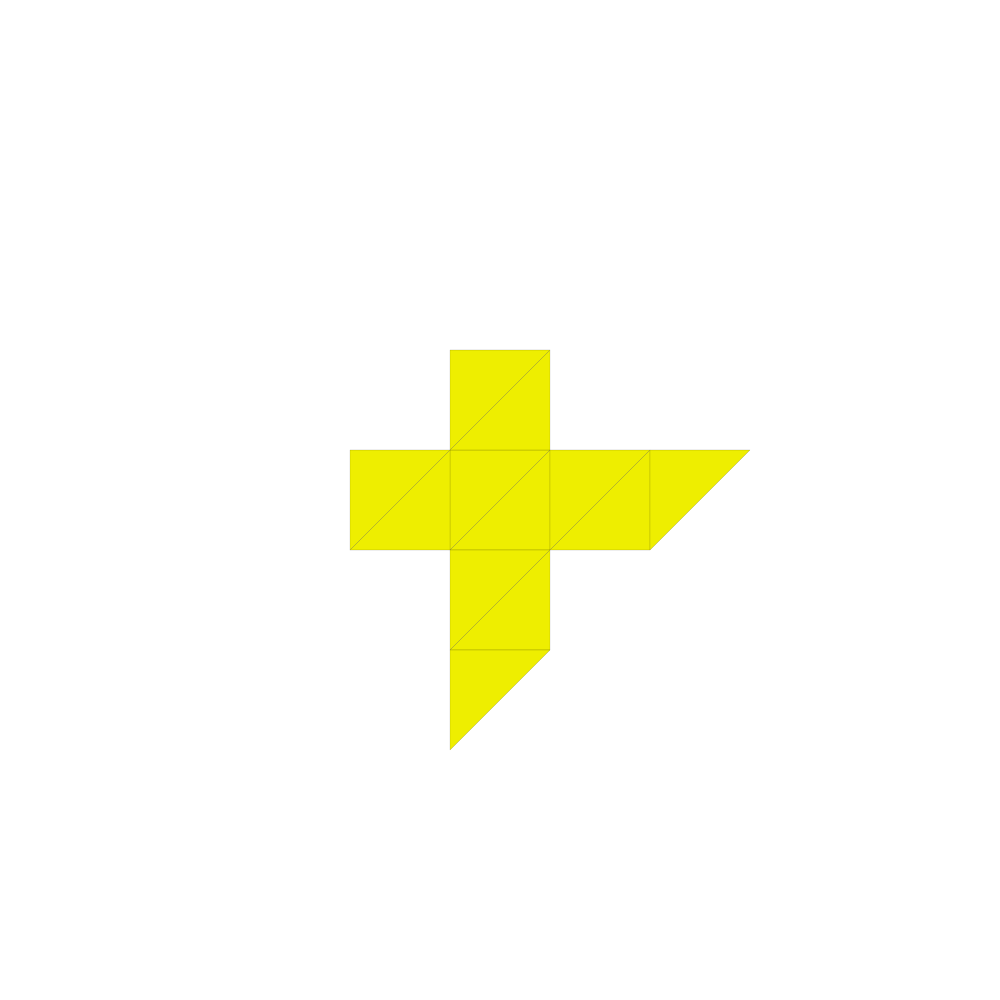

In [19]:
mesh = om.read_polymesh('cube.stl')
mesh.update_normals()

spanning_tree = bfs(mesh, mesh.face_handle(0))

polygons = unfold(mesh, spanning_tree)

# generate svg visualization
drawing = None
drawing = draw.Drawing(1000, 1000, origin='center')
for polygon in polygons:
    # polygon = [coords[0:2] for coords in polygon]
    drawing.append(draw.Lines(*np.array(polygon).flatten()*50, close=True, fill='#eeee00', stroke='#000', stroke_width=.1))

drawing

In [15]:
spanning_tree = bfs(mesh, mesh.face_handle(0))
